# Лекция 12: Оценка и валидация моделей машинного обучения

## Содержание лекции:
1. Введение в валидацию моделей
2. Методы разделения данных
3. Кросс-валидация
4. Метрики оценки качества
5. Bias-Variance Tradeoff
6. Выбор модели и гиперпараметров
7. Статистическая значимость
8. Лучшие практики
9. Практические примеры

## 1. Введение в валидацию моделей

### Зачем нужна валидация?

**Основные цели:**
- Оценить реальную производительность модели
- Избежать переобучения (overfitting)
- Сравнить различные модели
- Настроить гиперпараметры
- Получить надежные оценки качества

### Проблемы при неправильной валидации:
- **Data Leakage** - утечка информации из тестовых данных
- **Overfitting** - переобучение на тренировочных данных
- **Selection Bias** - смещение при выборе модели
- **Optimistic Bias** - завышенные оценки качества

In [5]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, validation_curve, learning_curve
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.datasets import make_classification, make_regression, load_breast_cancer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Настройка графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [4]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.7 MB 4.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.4/8.7 MB 5.6 MB/s eta 0:00:02
   ---------------- ----------------------- 3.7/8.7 MB 6.1 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.2 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.7 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Методы разделения данных

### 2.1 Простое разделение (Hold-out)

**Стандартное разделение:** 70% обучение, 15% валидация, 15% тест

Размер исходного набора данных: (1000, 20)
Размер обучающего набора: (700, 20) (70.0%)
Размер валидационного набора: (150, 20) (15.0%)
Размер тестового набора: (150, 20) (15.0%)


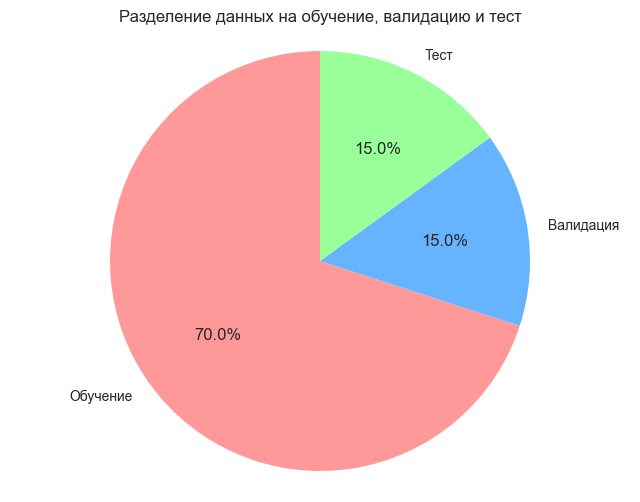

In [6]:
# Создание демонстрационного набора данных
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                         n_redundant=10, n_clusters_per_class=1, random_state=42)

print(f"Размер исходного набора данных: {X.shape}")

# Разделение на обучение и тест
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Разделение обучающего набора на обучение и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"Размер обучающего набора: {X_train.shape} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Размер валидационного набора: {X_val.shape} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Размер тестового набора: {X_test.shape} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Визуализация разделения
sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
labels = ['Обучение', 'Валидация', 'Тест']
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Разделение данных на обучение, валидацию и тест')
plt.axis('equal')
plt.show()

### 2.2 Стратифицированное разделение

Важно для несбалансированных классов - сохраняет пропорции классов во всех наборах.

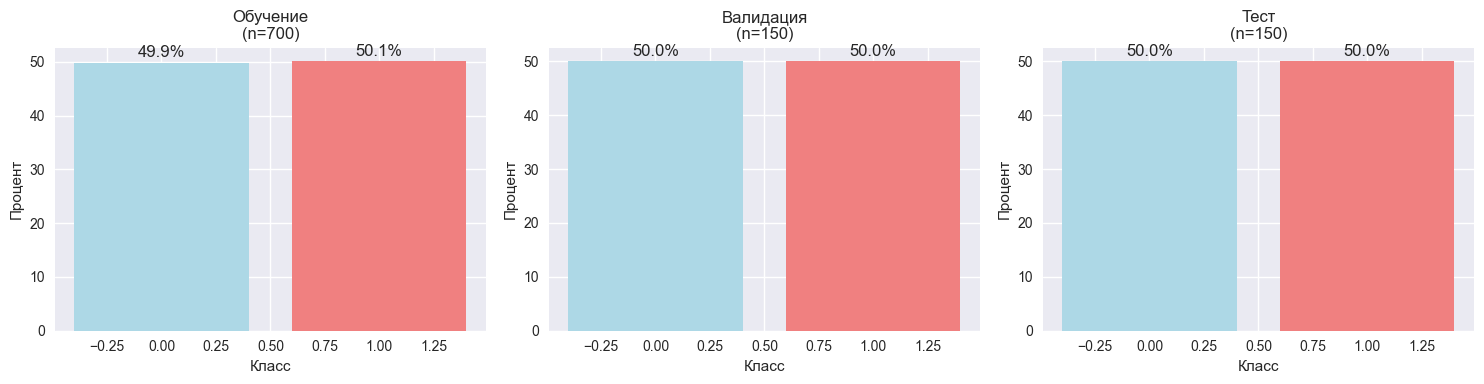

In [7]:
# Проверка распределения классов
def check_class_distribution(y_sets, labels):
    fig, axes = plt.subplots(1, len(y_sets), figsize=(15, 4))
    
    for i, (y_set, label) in enumerate(zip(y_sets, labels)):
        unique, counts = np.unique(y_set, return_counts=True)
        percentages = counts / len(y_set) * 100
        
        axes[i].bar(unique, percentages, color=['lightblue', 'lightcoral'])
        axes[i].set_title(f'{label}\n(n={len(y_set)})')
        axes[i].set_ylabel('Процент')
        axes[i].set_xlabel('Класс')
        
        # Добавление процентов на столбцы
        for j, (cls, pct) in enumerate(zip(unique, percentages)):
            axes[i].text(j, pct + 1, f'{pct:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()

check_class_distribution([y_train, y_val, y_test], ['Обучение', 'Валидация', 'Тест'])

## 3. Кросс-валидация

### 3.1 K-Fold Cross-Validation

Разделяет данные на k равных частей (фолдов), использует k-1 для обучения, 1 для валидации.

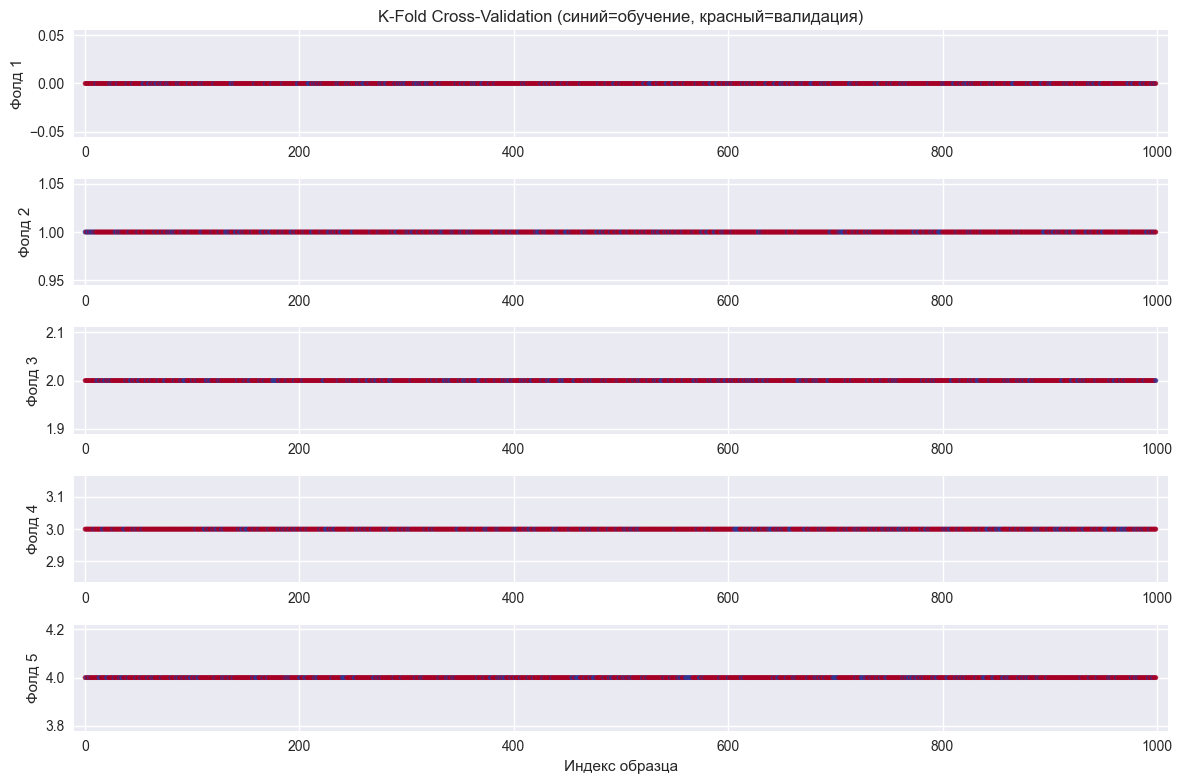

In [8]:
from sklearn.model_selection import KFold

# Демонстрация K-Fold разделения
def visualize_kfold(X, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    plt.figure(figsize=(12, 8))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Создание массива для визуализации
        colors = np.ones(len(X))
        colors[train_idx] = 0  # Обучение - синий
        colors[val_idx] = 1    # Валидация - красный
        
        plt.subplot(k, 1, fold + 1)
        plt.scatter(range(len(X)), [fold] * len(X), c=colors, 
                   cmap='RdYlBu', alpha=0.8, s=10)
        plt.ylabel(f'Фолд {fold + 1}')
        plt.xlim(-10, len(X) + 10)
        
        if fold == 0:
            plt.title('K-Fold Cross-Validation (синий=обучение, красный=валидация)')
        if fold == k - 1:
            plt.xlabel('Индекс образца')
    
    plt.tight_layout()
    plt.show()

# Визуализация 5-fold CV
visualize_kfold(X, k=5)

### 3.2 Стратифицированная кросс-валидация

Сравнение методов кросс-валидации:
   Фолд  K-Fold  Stratified K-Fold
0     1   0.955              0.960
1     2   0.970              0.975
2     3   0.965              0.965
3     4   0.960              0.970
4     5   0.960              0.935

Средняя точность K-Fold: 0.9620 ± 0.0051
Средняя точность Stratified K-Fold: 0.9610 ± 0.0139


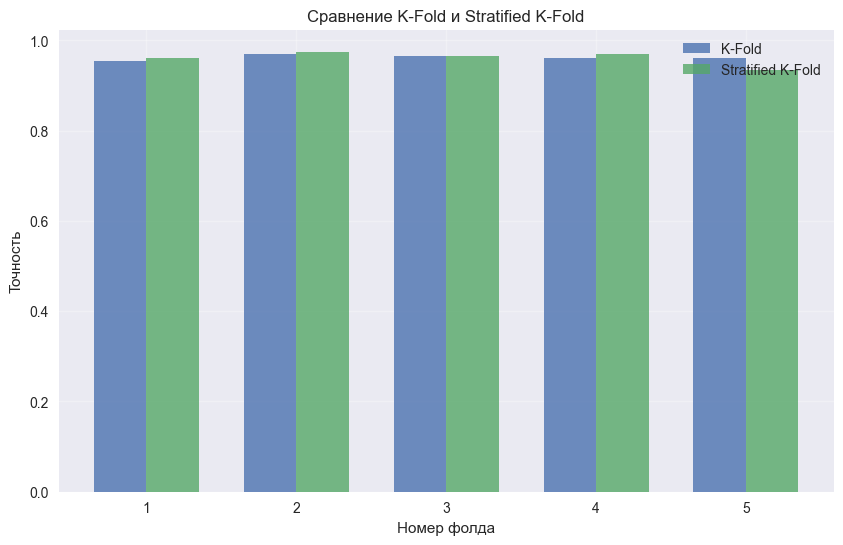

In [9]:
# Сравнение обычной и стратифицированной кросс-валидации
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Создание модели
model = LogisticRegression(random_state=42, max_iter=1000)

# Обычная кросс-валидация
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# Стратифицированная кросс-валидация
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_skfold = cross_val_score(model, X, y, cv=skfold, scoring='accuracy')

# Сравнение результатов
results_df = pd.DataFrame({
    'Фолд': range(1, 6),
    'K-Fold': scores_kfold,
    'Stratified K-Fold': scores_skfold
})

print("Сравнение методов кросс-валидации:")
print(results_df.round(4))
print(f"\nСредняя точность K-Fold: {scores_kfold.mean():.4f} ± {scores_kfold.std():.4f}")
print(f"Средняя точность Stratified K-Fold: {scores_skfold.mean():.4f} ± {scores_skfold.std():.4f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['K-Fold'], width, label='K-Fold', alpha=0.8)
plt.bar(x + width/2, results_df['Stratified K-Fold'], width, label='Stratified K-Fold', alpha=0.8)

plt.xlabel('Номер фолда')
plt.ylabel('Точность')
plt.title('Сравнение K-Fold и Stratified K-Fold')
plt.xticks(x, results_df['Фолд'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Метрики оценки качества

### 4.1 Метрики для задач классификации

#### Основные метрики:
- **Accuracy** - общая точность
- **Precision** - точность (из предсказанных положительных, сколько действительно положительных)
- **Recall** - полнота (из всех положительных, сколько найдено)
- **F1-Score** - гармоническое среднее precision и recall

Метрики классификации:
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-Score:  0.9861
AUC-ROC:   0.9954


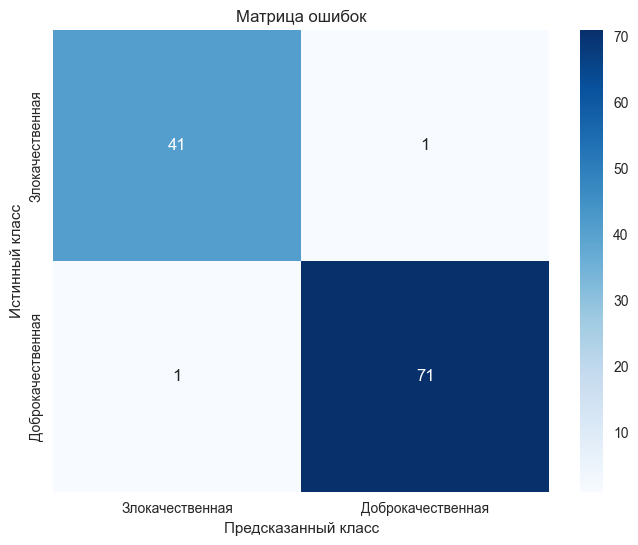

In [10]:
# Загрузка реального датасета
data = load_breast_cancer()
X_real, y_real = data.data, data.target

# Разделение данных
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

# Обучение модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_real)
X_test_scaled = scaler.transform(X_test_real)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train_real)

# Предсказания
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Вычисление метрик
accuracy = accuracy_score(y_test_real, y_pred)
precision = precision_score(y_test_real, y_pred)
recall = recall_score(y_test_real, y_pred)
f1 = f1_score(y_test_real, y_pred)
auc = roc_auc_score(y_test_real, y_pred_proba)

print("Метрики классификации:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test_real, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Злокачественная', 'Доброкачественная'],
            yticklabels=['Злокачественная', 'Доброкачественная'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

### 4.2 ROC-кривая и Precision-Recall кривая

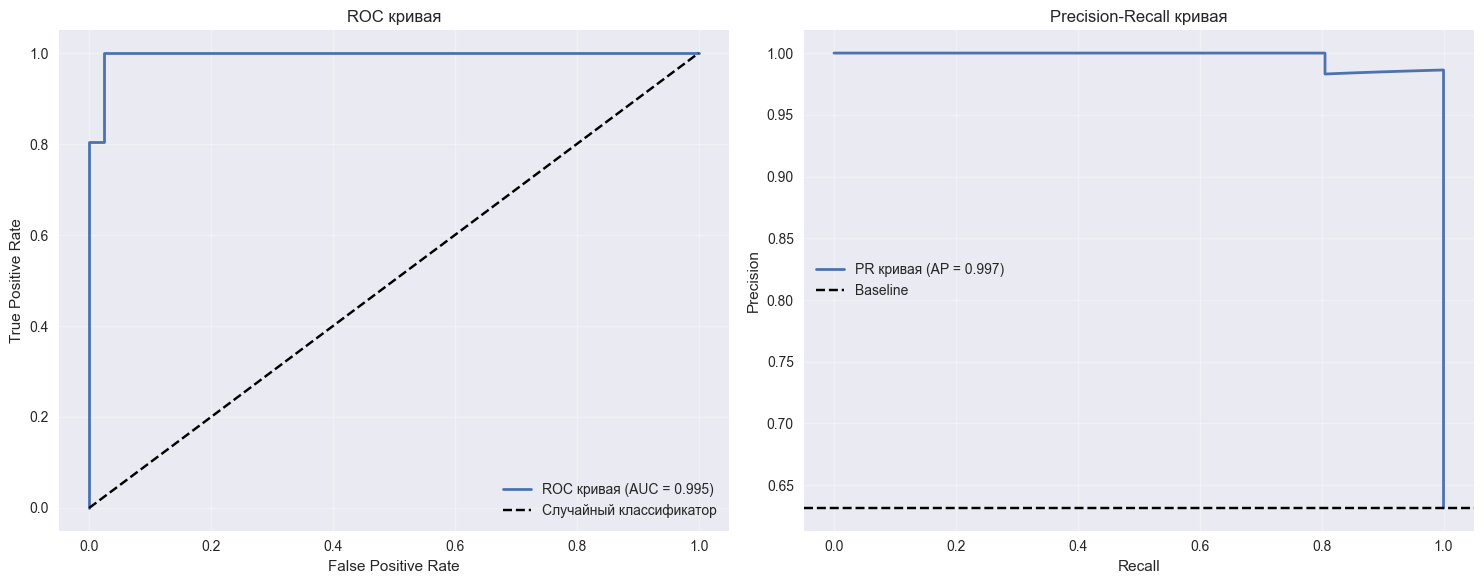

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# ROC кривая
fpr, tpr, thresholds_roc = roc_curve(y_test_real, y_pred_proba)

# Precision-Recall кривая
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test_real, y_pred_proba)
ap_score = average_precision_score(y_test_real, y_pred_proba)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC кривая
ax1.plot(fpr, tpr, linewidth=2, label=f'ROC кривая (AUC = {auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC кривая')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall кривая
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'PR кривая (AP = {ap_score:.3f})')
ax2.axhline(y=y_test_real.mean(), color='k', linestyle='--', label='Baseline')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall кривая')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Метрики для задач регрессии

Метрики регрессии:
MSE (Mean Squared Error):     116.8436
RMSE (Root Mean Squared Error): 10.8094
MAE (Mean Absolute Error):    8.5217
R² Score:                     0.9739


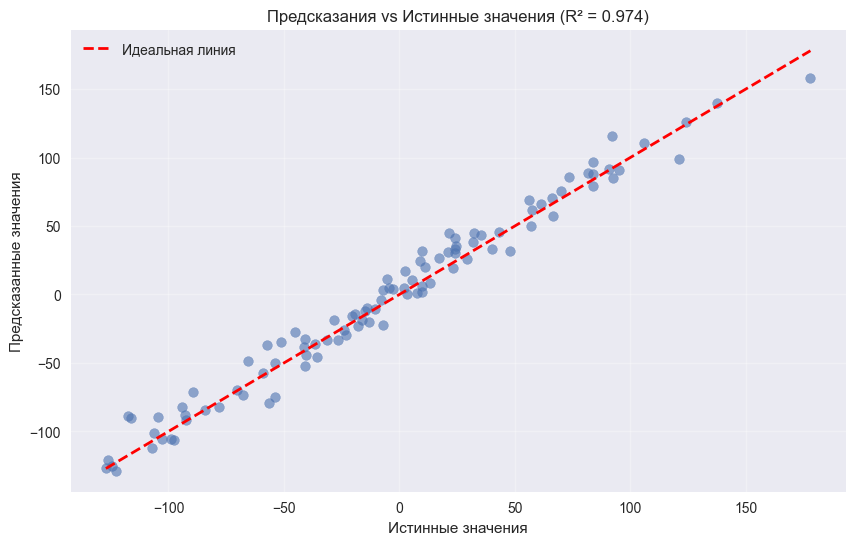

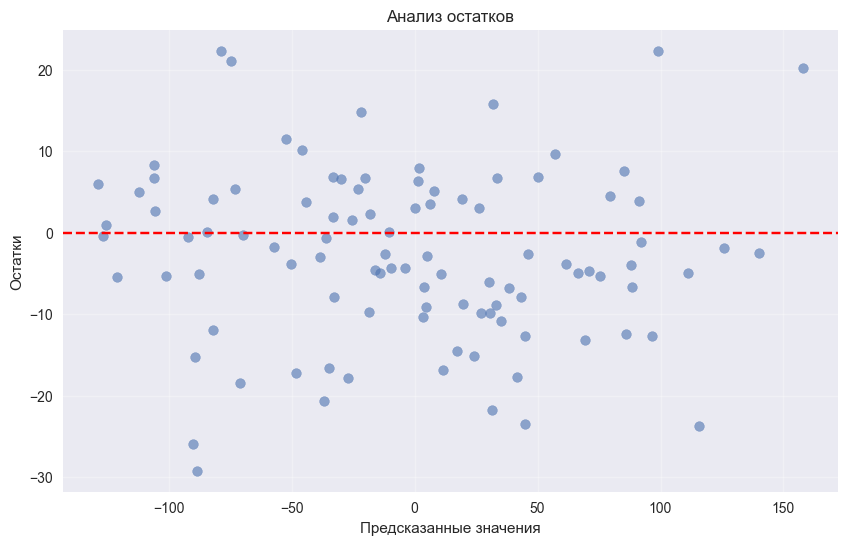

In [12]:
# Создание регрессионного датасета
X_reg, y_reg = make_regression(n_samples=500, n_features=10, n_informative=5, 
                              noise=10, random_state=42)

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Обучение модели
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg = reg_model.predict(X_test_reg)

# Метрики регрессии
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Метрики регрессии:")
print(f"MSE (Mean Squared Error):     {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")

# Визуализация предсказаний vs истинных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Предсказания vs Истинные значения (R² = {r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Распределение остатков
residuals = y_test_reg - y_pred_reg

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_reg, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Bias-Variance Tradeoff

### 5.1 Концепция компромисса смещение-разброс

**Общая ошибка = Смещение² + Разброс + Шум**

- **Bias (Смещение)** - систематическая ошибка модели
- **Variance (Разброс)** - чувствительность к изменениям в данных
- **Noise (Шум)** - неустранимая ошибка в данных

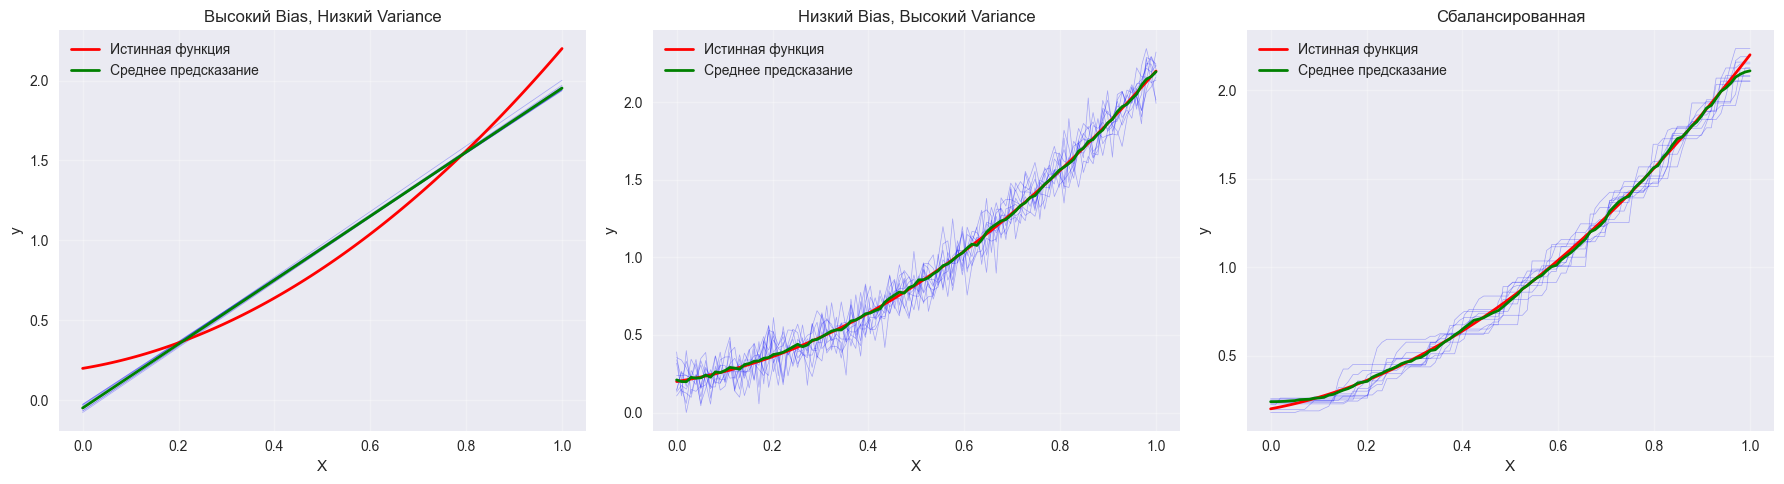

In [13]:
# Демонстрация bias-variance tradeoff
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

def bias_variance_demo():
    # Создание синтетических данных
    np.random.seed(42)
    n_samples = 100
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    
    # Истинная функция
    def true_function(x):
        return 1.5 * x**2 + 0.5 * x + 0.2
    
    y_true = true_function(X.ravel())
    
    # Модели с разным bias-variance
    models = {
        'Высокий Bias, Низкий Variance': LinearRegression(),
        'Низкий Bias, Высокий Variance': DecisionTreeRegressor(max_depth=10, random_state=42),
        'Сбалансированная': BaggingRegressor(DecisionTreeRegressor(max_depth=3), 
                                           n_estimators=10, random_state=42)
    }
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, model) in enumerate(models.items()):
        predictions = []
        
        # Генерация нескольких версий данных с шумом
        for i in range(100):
            # Добавление шума
            y_noisy = y_true + np.random.normal(0, 0.1, len(y_true))
            
            # Обучение модели
            model.fit(X, y_noisy)
            pred = model.predict(X)
            predictions.append(pred)
            
            # Показываем только первые несколько предсказаний
            if i < 10:
                axes[idx].plot(X.ravel(), pred, alpha=0.3, color='blue', linewidth=0.5)
        
        # Среднее предсказание
        mean_pred = np.mean(predictions, axis=0)
        
        # Истинная функция
        axes[idx].plot(X.ravel(), y_true, 'r-', linewidth=2, label='Истинная функция')
        axes[idx].plot(X.ravel(), mean_pred, 'g-', linewidth=2, label='Среднее предсказание')
        
        axes[idx].set_title(name)
        axes[idx].set_xlabel('X')
        axes[idx].set_ylabel('y')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

bias_variance_demo()

### 5.2 Кривые обучения (Learning Curves)

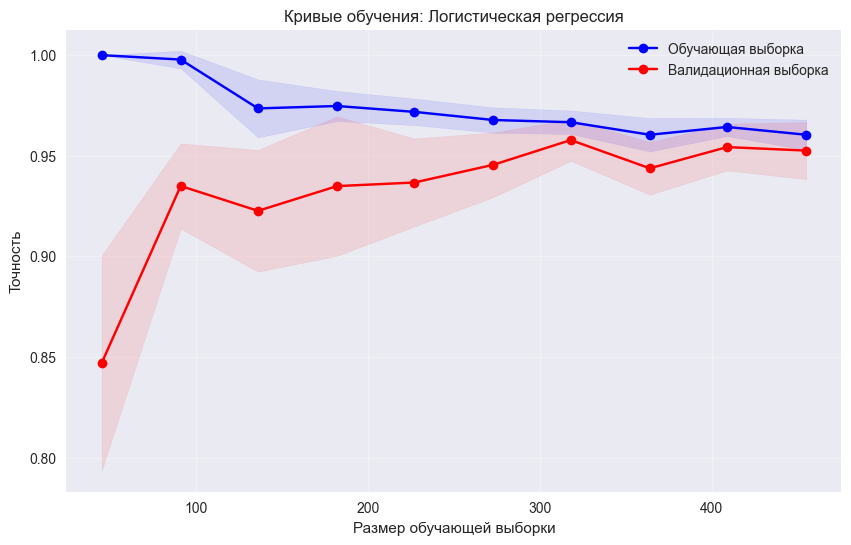

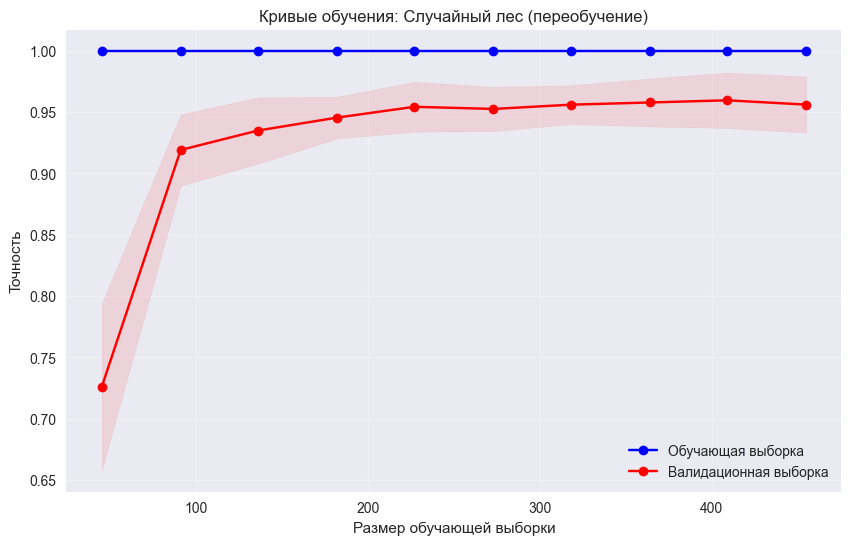

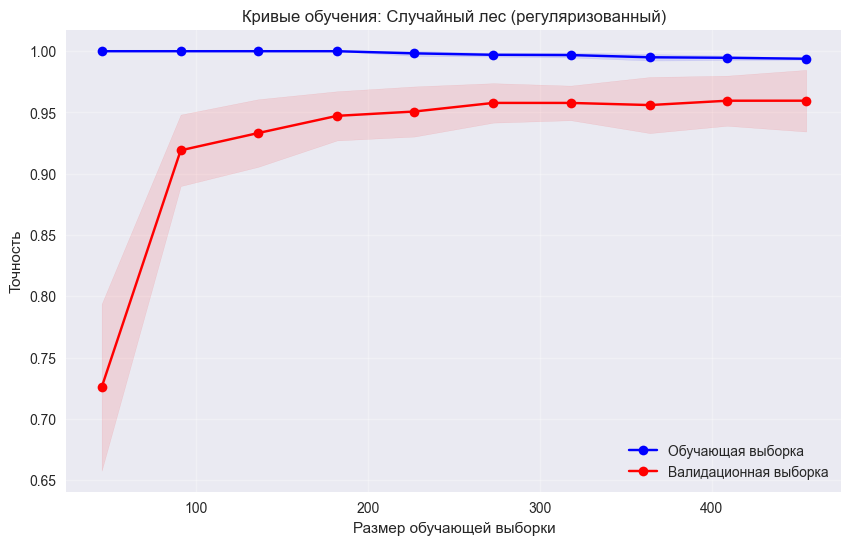

In [14]:
# Построение кривых обучения
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Обучающая выборка')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Валидационная выборка')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('Точность')
    plt.title(f'Кривые обучения: {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return train_sizes, train_scores, val_scores

# Сравнение разных моделей
models_comparison = {
    'Логистическая регрессия': LogisticRegression(random_state=42, max_iter=1000),
    'Случайный лес (переобучение)': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    'Случайный лес (регуляризованный)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

for name, model in models_comparison.items():
    plot_learning_curves(model, X_real, y_real, name)

## 6. Выбор модели и гиперпараметров

### 6.1 Grid Search с Cross-Validation

In [11]:
# Настройка гиперпараметров для Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='accuracy', 
    n_jobs=-1, verbose=1
)

print("Выполняется Grid Search...")
grid_search.fit(X_train_scaled, y_train_real)

print("\nЛучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nЛучший результат CV: {grid_search.best_score_:.4f}")

# Тестирование лучшей модели
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test_real)
print(f"Результат на тестовой выборке: {test_score:.4f}")

Выполняется Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Лучшие параметры:
max_depth: 7
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 50

Лучший результат CV: 0.9604
Результат на тестовой выборке: 0.9474

Лучшие параметры:
max_depth: 7
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 50

Лучший результат CV: 0.9604
Результат на тестовой выборке: 0.9474


### 6.2 Validation Curves - влияние отдельных гиперпараметров

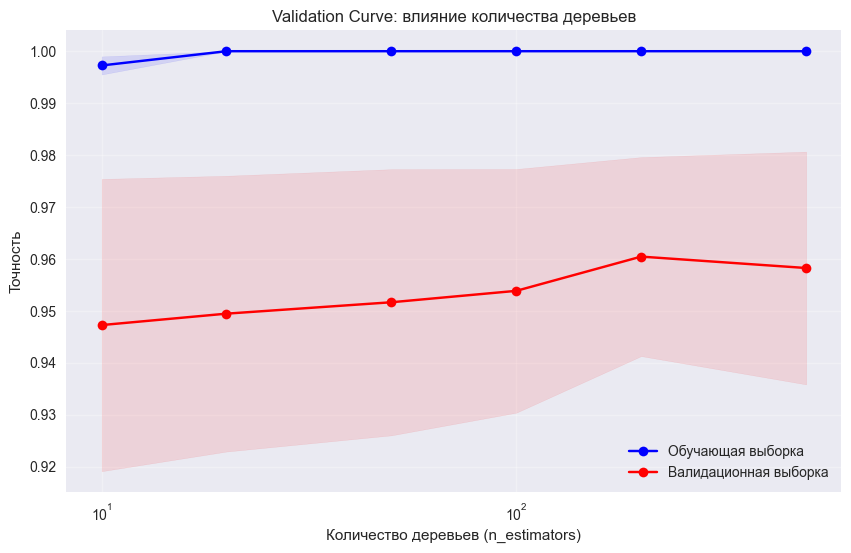

Оптимальное количество деревьев: 200
Точность валидации: 0.9604 ± 0.0192


In [12]:
# Анализ влияния количества деревьев
param_range = [10, 20, 50, 100, 200, 500]

train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42), X_train_scaled, y_train_real,
    param_name='n_estimators', param_range=param_range,
    cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_mean, 'o-', color='blue', label='Обучающая выборка')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.semilogx(param_range, val_mean, 'o-', color='red', label='Валидационная выборка')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Точность')
plt.title('Validation Curve: влияние количества деревьев')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Найдем оптимальное значение
best_idx = np.argmax(val_mean)
print(f"Оптимальное количество деревьев: {param_range[best_idx]}")
print(f"Точность валидации: {val_mean[best_idx]:.4f} ± {val_std[best_idx]:.4f}")

## 7. Статистическая значимость

### 7.1 Сравнение моделей с помощью t-теста

Сравнение моделей:
Логистическая регрессия: 0.9526 ± 0.0249
Случайный лес:          0.9561 ± 0.0239

Разность: 0.0035 ± 0.0172
t-статистика: 0.6124
p-значение: 0.5554

Различие не является статистически значимым (p >= 0.05)


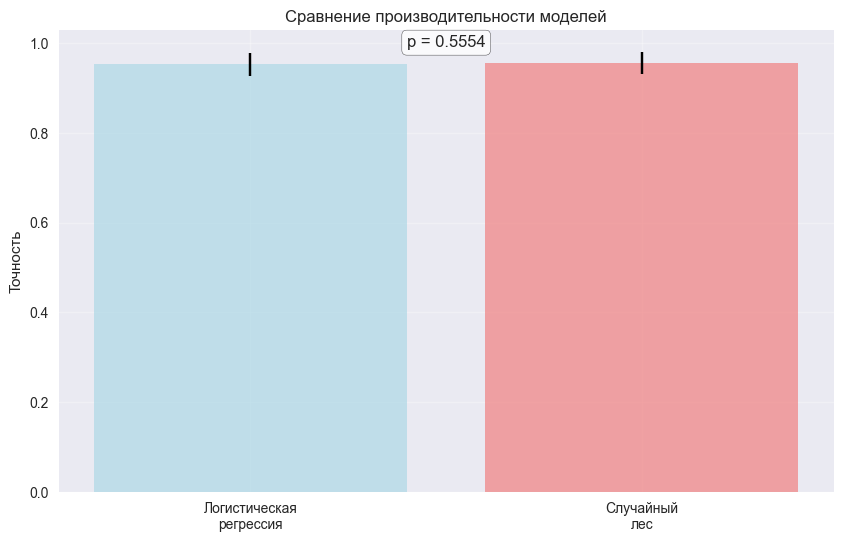

In [13]:
from scipy import stats

# Сравнение двух моделей
model1 = LogisticRegression(random_state=42, max_iter=1000)
model2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Кросс-валидация для обеих моделей
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores1 = cross_val_score(model1, X_real, y_real, cv=cv, scoring='accuracy')
scores2 = cross_val_score(model2, X_real, y_real, cv=cv, scoring='accuracy')

# Статистическое сравнение
diff = scores2 - scores1
t_stat, p_value = stats.ttest_rel(scores2, scores1)

print("Сравнение моделей:")
print(f"Логистическая регрессия: {scores1.mean():.4f} ± {scores1.std():.4f}")
print(f"Случайный лес:          {scores2.mean():.4f} ± {scores2.std():.4f}")
print(f"\nРазность: {diff.mean():.4f} ± {diff.std():.4f}")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nРазличие статистически значимо (p < {alpha})")
else:
    print(f"\nРазличие не является статистически значимым (p >= {alpha})")

# Визуализация результатов
plt.figure(figsize=(10, 6))
x = ['Логистическая\nрегрессия', 'Случайный\nлес']
means = [scores1.mean(), scores2.mean()]
stds = [scores1.std(), scores2.std()]

plt.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color=['lightblue', 'lightcoral'])
plt.ylabel('Точность')
plt.title('Сравнение производительности моделей')
plt.grid(True, alpha=0.3)

# Добавление p-значения на график
y_max = max(means) + max(stds) + 0.01
plt.text(0.5, y_max, f'p = {p_value:.4f}', ha='center', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

## 8. Лучшие практики валидации

### 8.1 Общие рекомендации

1. **Всегда используйте отдельную тестовую выборку**
2. **Стратифицированное разделение для несбалансированных данных**
3. **Кросс-валидация для надежных оценок**
4. **Проверяйте на утечку данных (data leakage)**
5. **Используйте соответствующие метрики для задачи**

In [14]:
# Пример правильного pipeline для избежания data leakage
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# НЕПРАВИЛЬНО: предобработка до разделения
print("НЕПРАВИЛЬНЫЙ подход:")
X_scaled_wrong = StandardScaler().fit_transform(X_real)
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_scaled_wrong, y_real, test_size=0.2, random_state=42
)
model_wrong = LogisticRegression(random_state=42, max_iter=1000)
model_wrong.fit(X_train_wrong, y_train_wrong)
score_wrong = model_wrong.score(X_test_wrong, y_test_wrong)
print(f"Результат (с утечкой данных): {score_wrong:.4f}")

print("\nПРАВИЛЬНЫЙ подход:")
# ПРАВИЛЬНО: предобработка в pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=20)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

X_train_correct, X_test_correct, y_train_correct, y_test_correct = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

pipeline.fit(X_train_correct, y_train_correct)
score_correct = pipeline.score(X_test_correct, y_test_correct)
print(f"Результат (без утечки данных): {score_correct:.4f}")

# Кросс-валидация с pipeline
cv_scores = cross_val_score(pipeline, X_real, y_real, cv=5, scoring='accuracy')
print(f"CV результат: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

НЕПРАВИЛЬНЫЙ подход:
Результат (с утечкой данных): 0.9737

ПРАВИЛЬНЫЙ подход:
Результат (без утечки данных): 0.9737
CV результат: 0.9789 ± 0.0089


### 8.2 Специальные случаи валидации

#### Временные ряды - Time Series Split

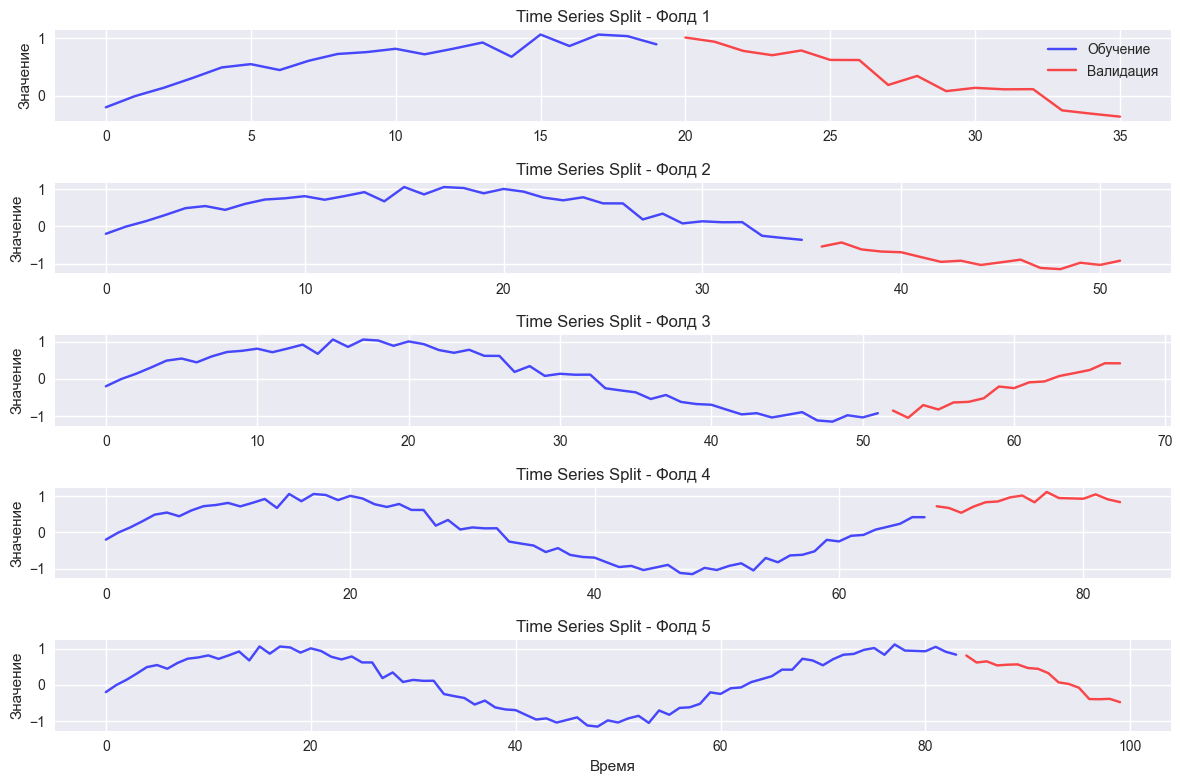

Time Series Split сохраняет временной порядок данных:
- Обучение всегда происходит на более ранних данных
- Валидация - на более поздних данных
- Имитирует реальное использование модели


In [15]:
from sklearn.model_selection import TimeSeriesSplit

# Симуляция временных данных
n_samples = 100
time_data = np.arange(n_samples).reshape(-1, 1)
time_target = np.sin(0.1 * np.arange(n_samples)) + np.random.normal(0, 0.1, n_samples)

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

plt.figure(figsize=(12, 8))

for fold, (train_idx, val_idx) in enumerate(tscv.split(time_data)):
    plt.subplot(5, 1, fold + 1)
    
    # Визуализация разделения
    plt.plot(train_idx, time_target[train_idx], 'b-', alpha=0.7, label='Обучение')
    plt.plot(val_idx, time_target[val_idx], 'r-', alpha=0.7, label='Валидация')
    
    plt.title(f'Time Series Split - Фолд {fold + 1}')
    plt.ylabel('Значение')
    
    if fold == 0:
        plt.legend()
    if fold == 4:
        plt.xlabel('Время')

plt.tight_layout()
plt.show()

print("Time Series Split сохраняет временной порядок данных:")
print("- Обучение всегда происходит на более ранних данных")
print("- Валидация - на более поздних данных")
print("- Имитирует реальное использование модели")

## 9. Практические примеры

### 9.1 Полный pipeline оценки модели


Оценка модели: Логистическая регрессия
CV: 0.9780 ± 0.0098
Test Accuracy: 0.9825

Оценка модели: Случайный лес
CV: 0.9626 ± 0.0179
Test Accuracy: 0.9561

Оценка модели: SVM
CV: 0.9692 ± 0.0146
Test Accuracy: 0.9825

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                          CV_mean    CV_std Test_accuracy Test_precision  \
Логистическая регрессия  0.978022  0.009829      0.982456       0.982456   
Случайный лес            0.962637  0.017855       0.95614       0.956073   
SVM                      0.969231  0.014579      0.982456       0.982456   

                        Test_recall   Test_f1  
Логистическая регрессия    0.982456  0.982456  
Случайный лес               0.95614  0.956027  
SVM                        0.982456  0.982456  
CV: 0.9626 ± 0.0179
Test Accuracy: 0.9561

Оценка модели: SVM
CV: 0.9692 ± 0.0146
Test Accuracy: 0.9825

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                          CV_mean    CV_std Test_accuracy Test_precision  \
Логистическая регрессия  0.978022  0.009829      

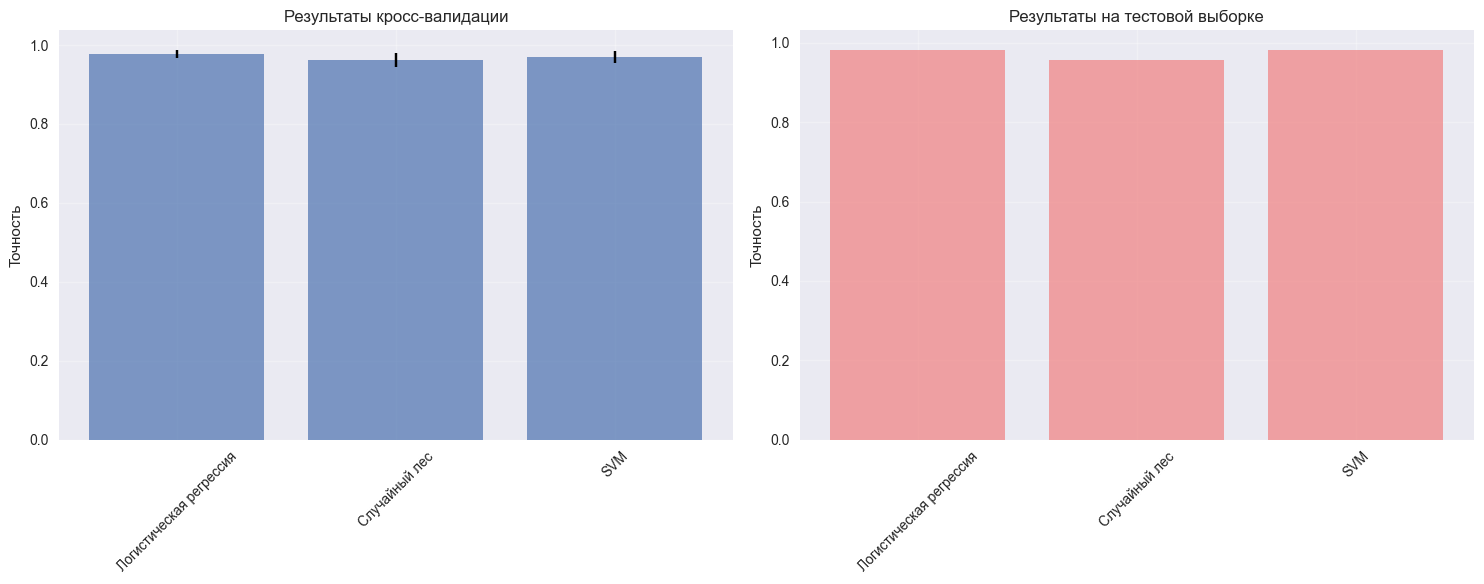

In [16]:
def comprehensive_model_evaluation(X, y, models, cv_folds=5):
    """
    Комплексная оценка нескольких моделей
    """
    results = {}
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Кросс-валидация для каждой модели
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nОценка модели: {name}")
        
        # Кросс-валидация
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # Обучение на полном тренировочном наборе
        model.fit(X_train, y_train)
        
        # Предсказания
        y_pred = model.predict(X_test)
        
        # Метрики
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred, average='weighted')
        test_recall = recall_score(y_test, y_pred, average='weighted')
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Сохранение результатов
        results[name] = {
            'CV_mean': cv_scores.mean(),
            'CV_std': cv_scores.std(),
            'Test_accuracy': test_accuracy,
            'Test_precision': test_precision,
            'Test_recall': test_recall,
            'Test_f1': test_f1,
            'CV_scores': cv_scores
        }
        
        print(f"CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return results

# Определение моделей для сравнения
models_to_compare = {
    'Логистическая регрессия': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Случайный лес': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

# Комплексная оценка
evaluation_results = comprehensive_model_evaluation(X_real, y_real, models_to_compare)

# Создание сводной таблицы
results_df = pd.DataFrame(evaluation_results).T
results_df = results_df[['CV_mean', 'CV_std', 'Test_accuracy', 'Test_precision', 'Test_recall', 'Test_f1']]

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)
print(results_df.round(4))

# Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CV результаты
models_names = list(evaluation_results.keys())
cv_means = [evaluation_results[name]['CV_mean'] for name in models_names]
cv_stds = [evaluation_results[name]['CV_std'] for name in models_names]

ax1.bar(models_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
ax1.set_title('Результаты кросс-валидации')
ax1.set_ylabel('Точность')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Тестовые результаты
test_accuracies = [evaluation_results[name]['Test_accuracy'] for name in models_names]

ax2.bar(models_names, test_accuracies, alpha=0.7, color='lightcoral')
ax2.set_title('Результаты на тестовой выборке')
ax2.set_ylabel('Точность')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Заключение

### Ключевые выводы:

1. **Правильная валидация критически важна** для получения надежных оценок производительности модели

2. **Выбор метода валидации зависит от данных:**
   - Обычная кросс-валидация для стандартных задач
   - Стратифицированная для несбалансированных классов
   - Time Series Split для временных данных

3. **Метрики должны соответствовать задаче:**
   - Accuracy для сбалансированных классов
   - Precision/Recall для несбалансированных
   - AUC-ROC для ранжирования
   - MSE/MAE для регрессии

4. **Избегайте data leakage** используя Pipeline

5. **Статистическая значимость** помогает принимать обоснованные решения при сравнении моделей

6. **Bias-Variance tradeoff** объясняет поведение различных моделей

### Следующие шаги:
- Практическое применение изученных методов
- Изучение продвинутых техник валидации
- Работа с реальными проектами